# Covariance for Angular Power Spectra with *Heracles*

This notebook demonstrates how *Heracles* computes an estimate of the covariance of the two-point statistics from a 3×2pt catalogue using the DICES method. This tutorial is heavily based on the summary statisitcs tutorial so we will reproduce the results found in said tutorial without going into the details of the analysis. We will then show how to compute the covariance of the angular power spectra using *Heracles*.

<div class="alert alert-info">

**Important note**

This notebook is only meant to give you an idea of **how *Heracles* works**.

It does **not** show everything that *Heracles* can do.

**This is a toy, treat it is such!**

</div>

## Setup

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import heracles
import heracles.healpy
from heracles.notebook import Progress

# Covariance code
import heracles.dices as dices

import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

## Basic parameters

This is the resolution parameter for measuring spectra from *HEALPix* maps.  Here, we use `nside = 128` since that is the resolution at which the example data has been created. A value `lmax` of approximate 1.5x `nside` is fairly safe in terms of errors introduced by *HEALPix*. For the purpose of this tutorial we will only use 3 tomographic bins.

In [2]:
nside = 128
lmax = 150
nbins = 3

## Prepare maps

For this tutorial we will use the same data as in the summary statistics tutorial. Note that the maps generated in the summary statistics tutorial might have a different resolution. Therefore we will have to up/down-scale them accordingly. Doing so, unfortunately destroys the metadata of the maps. Therefore we will have to manually re-enter the metadata.

In [3]:
from heracles.healpy import HealpixMapper
from heracles.fields import Positions, Shears, Visibility, Weights

data_maps = heracles.read_maps("example-data_maps.fits")
mapper = HealpixMapper(nside=nside, lmax=lmax)
fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}

In [4]:
data_maps = heracles.read_maps("example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)
heracles.update_metadata(
            vis_map,
            nside=nside,
            lmax=lmax,
            bias=0.0,
            fsky=meta["fsky"],
            spin=0,
        )
vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

## Jackknife Regions

The fundamental idea behind Jackknife approaches is to generate an ensemble of angular power spectra by leaving out one of the regions at a time. The covariance of the angular power spectra can then be estimated from the variance of the ensemble. Therefore, the first step is to divide the mask of the survey into regions. In order to do so, in this tutorial we will make use of the SkySegmentor library. However, any library that segments the sky into regions can be used.

In [5]:
import skysegmentor

In [6]:
jk_maps = {}
Njk = 10
jk_map = skysegmentor.segmentmapN(vis_map, Njk)
for key in list(vis_maps.keys()):
    jk_maps[key] = jk_map

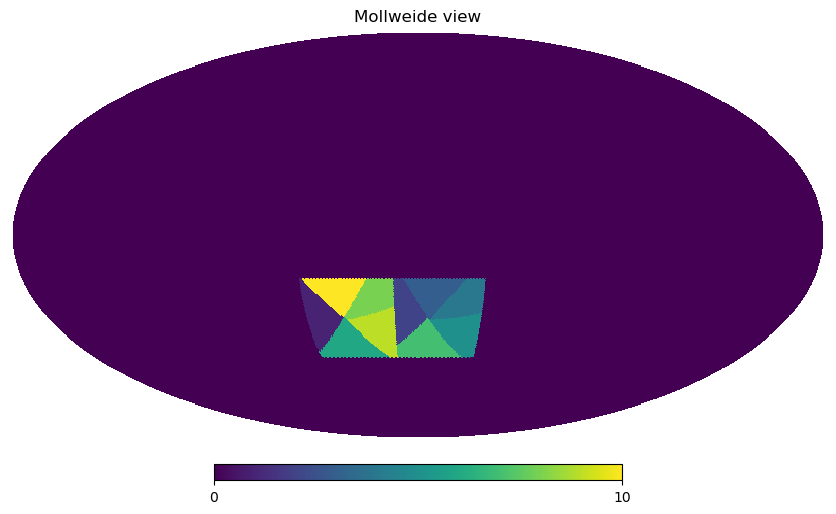

In [7]:
hp.mollview(jk_maps[("VIS", 1)])

## Two-point statistics

Since the computation of the two-point statistics was already covered in the summary statistics tutorial, we will not go into the details of the analysis. We will simply load the results from the summary statistics tutorial and use them to compute the covariance of the angular power spectra.

In [8]:
cls0 = dices.jackknife_cls(data_maps, vis_maps, jk_maps, fields, nd=0)[()]

## Theory

Similarly, in this tutorial we will limit ourselves to loading the thoeory power spectra from the summary statistics tutorial.

In [9]:
theory = heracles.read("example-theory.fits")
theory_cls = {}
for key in list(cls0.keys()):
    theory_cls[key] = theory[key][..., : lmax + 1]

## Ensemble Computation

Compute the ensemble of angular power spectrum effectively boils down to repeating the process presented in the two-point statistics section removing one of the jackknife regions at a time. However, a couple of extra considerations have to be made.


When computing the angular power spectra from catalogues, removing one of the jackknife regions changes the sample variance of the angular power spectra by a factor of 
$$
b_{jk} = b (1-\frac{1}{N})
$$

Moreover, removing of the jackknife regions also changes the footprint of the survey which can introduce additional mixing betweeen E- and B-modes. Heracles is equiped with a mask correction routine that corrects for this effect by transforming the angular power spectra to real space, dividing the correlation function of the ratio of new footprint to the old footprint and transforming back to harmonic space. 
$$
 C_\ell \rightarrow \xi(\theta) \\
 M_\ell \rightarrow \xi_m(\theta) \\
 M^{\rm jk}(\theta) \rightarrow \xi^{\rm jk}_m(\theta) \\
$$
$$
\bar{\xi}(\theta) = \xi(\theta) \frac{\xi_m(\theta)}{\xi^{\rm jk}_m(\theta)} \\
$$
$$
\bar{\xi}(\theta) \rightarrow \bar{C}_\ell
$$

In [10]:
cls1 = dices.jackknife_cls(data_maps, vis_maps, jk_maps, fields, nd=1)

To add numerically stability to our computations, we will also bin the ensemble of angular power spectra.

In [11]:
nlbins = 10
ell = np.arange(lmax + 1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

In [12]:
cqs0 = heracles.binned(cls0, ledges)
cqs1 = heracles.binned(cls1, ledges)

## Delete1 Covariance

The delete-one covariance is computed by measuring the covariance matrix of the ensemble of delete-one angular power spectra. The covariance matrix of an ensemble of $K$ vector variables $x \in \mathbb{R}^N$ is defined as:
$$
\mathbb{C}_{ij} = \mathbb{E} \left[ (x_i - \bar{x_i}) (x_j - \bar{x_j})^T \right]_k \, ,
$$
where $\bar{x_i} = \mathbb{E}[x_{ik}]_k = \frac{1}{K} \sum_k^K x_{ik}$ is the mean over the ensemble. Therefore, one can define any covariance matrix as an expectation over an ensemble of matrices with entries:
$$
W(x)_{ijk} = (x_{ik} - \bar{x_i}) (x_{jk} - \bar{x_j}) \, .
$$
such that $\mathbb{C}_{ij} = \mathbb{E} [W(x)_{ijk}]_k$.

In order to use formalism above to compute the delete-one covariance we have to start by generating an ensemble of concatenated angular power spectra. In other words, assume we are computing the angular power spectra of $F$ fields combinations, we have to go to $F$ ensembles of K entries, where each entry angular power spectrum is a vector of $N$ elements to an ensemble of $K$ entries where each entry vector has $F \times N$ elements. We will refer to the concatenated angular power spectra as the ensemble of data vectors $d^1 \in \mathbb{R}^{F \times N}$. Substitutin $x$ for $d$ in the previous equation, the computation of the delete-one covariance is then given by:
$$
\mathbb{C}^{\rm JK}_{ij} = (K-1) \mathbb{E} [W(d^1)_{ijk}]_k \, .
$$

Analyzing the equation above we can understand better the Jackknife approach. As we increase the number of jackknife regions, the size of each indiviual regions decreases meaning that
$$
\rm{lim}_{K \rightarrow \infty} (d_{ik} - \bar{d_i}) = 0 \, ,
$$
such that $W_{ijk} \rightarrow 0$ and thus $\mathbb{E} [W_{ijk}]_k \rightarrow 0$.
However, the prefactor $(K-1)$ ensures that the Jackknige covariance doesn't vanish as $K$ increases.

In [13]:
cov_jk = dices.jackknife_covariance(cqs0, cqs1)

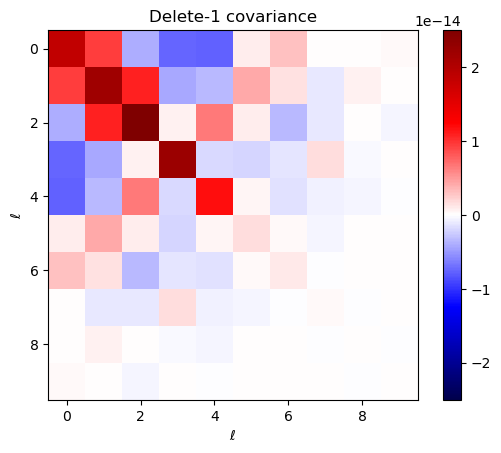

In [14]:
plt.imshow(cov_jk[("POS", "POS", "POS", "POS", 1, 1, 1, 1)], 
           vmin=-2.5*10**-14, vmax=2.5*10**-14, cmap="seismic")
plt.colorbar()
plt.title("Delete-1 covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## Shrinkage

To improve the stability of the off-diagonal elements of the covariance matrix, we can apply a linear shrinkage to a Gaussian target. Since we don't have access to theory $C_{\ell}'s$, the Gaussian target is computed from the mean $C_{\ell}$'s in the ensemble using the known formula:
$$
\mathbb{G}^{abcd} = \frac{(C_{\ell}^{ab}+b^{ab}) (C_{\ell}^{cd}+b^{cd}) + (C_{\ell}^{ac}+b^{ac}) (C_{\ell}^{bd}+b^{bd})}{2 \ell + 1} \, ,
$$
withour taking into account the partial sky.

To ensure that the diagonal elements of $\mathbb{C}^1$ remain unchanged, we modify $\mathbb{G}$ as:
$$
\tilde{\mathbb{G}}_{ii} = \mathbb{C}^{\rm JK}_{ii} \\
\tilde{\mathbb{G}}_{ij} = \mathbb{G}_{ij} \sqrt{\mathbb{C}^{\rm JK}_{ii} \mathbb{C}^{\rm JK}_{ij}}\, .
$$
The shrunk covariance matrix is then given by:
$$
\mathbb{C}^{\rm shrunk} = \lambda \tilde{\mathbb{G}} + (1-\lambda) \mathbb{C}^{\rm JK} \, ,
$$
where $\lambda$ is the shrinkage factor. The computation of the shrinkage factor is a complex process and is not covered in this tutorial.

In [15]:
theory_cqs = heracles.binned(theory_cls, ledges)
target_cov = dices.gaussian_covariance(theory_cqs)
shrinkage = dices.shrinkage_factor(cqs0, cqs1, target_cov)
print("Shrinkage factor: ", shrinkage)

Shrinkage factor:  0.012058136208785935


In [16]:
shrunk_cov_jk = dices.shrink_covariance(
    cqs0,
    cov_jk, 
    target_cov,
    shrinkage)

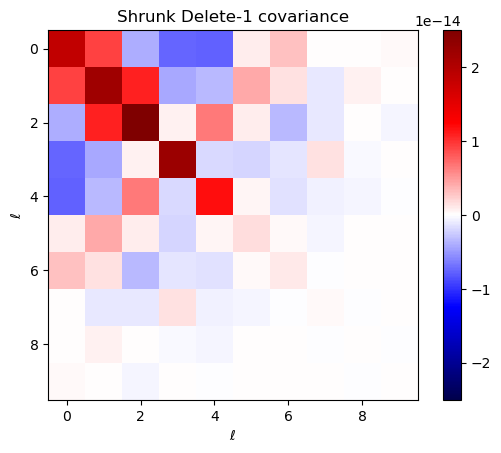

In [17]:
plt.imshow(shrunk_cov_jk[("POS", "POS", "POS", "POS", 1, 1, 1, 1)],
           vmin=-2.5*10**-14, vmax=2.5*10**-14, cmap="seismic")
plt.colorbar()
plt.title("Shrunk Delete-1 covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## Debiasing

It can be shown that the Jackknife covariance errors (i.e. its diagonal entries) tend to be biased high. In other words, the Jackknife covariance matrix overestimates the variances of the angular power spectra. In order to address this, the DICES covariances introduces a second ensemble of angular power spectra, the delete-two ensemble. The delete-two ensemble is computed by removing two jackknife regions at a time

In [18]:
cls2 = dices.jackknife_cls(data_maps, vis_maps, jk_maps, fields, nd=2)
cqs2 = heracles.binned(cls2, ledges)

Once, the delete-two ensemble is computed, the correction can be obtained by computing the expressions:
$$
q_{p} = K d^0 - (K-1) (d_k^1 + d_{k'}^1) + (K-2) d^2_{p} \, ,
$$
where $d^0$ denotes the concatenated angular power spectra of the full survey, $d^1_k$ and $d^1_{k'}$ denote the concatenated angular power spectra of the survey with the $k$-th and $k'$-th jackknife regions removed respectively, and $d^2_{p}$ denotes the concatenated angular power spectra of the survey with both the $k$-th and $k'$-th jackknife regions removed. Note that $p$ is an iterator that runs from 1 to $K(K-1)/2$ related to the combinations of $k$ and $k'$. 

Now we need to compute the variance of the q-ensemble. In order to do so, we can use the same framework as for the delete-one matrices substituting $q$ for $x$ in the expression for $W$. The correction is then given by:
$$
Q_{ij} = \frac{K(K-1)-2}{2K(K+1)} \mathbb{E} [W(q)_{ijp}]_{p} \, .
$$

Finally the debiased covariance matrix is given by:
$$
\mathbb{C}^{\rm debiased} = \mathbb{C}^{\rm JK} - Q \, .
$$

In [19]:
debiased_cov_jk = dices.debias_covariance(
    cov_jk,
    cqs0,
    cqs1,
    cqs2,
)

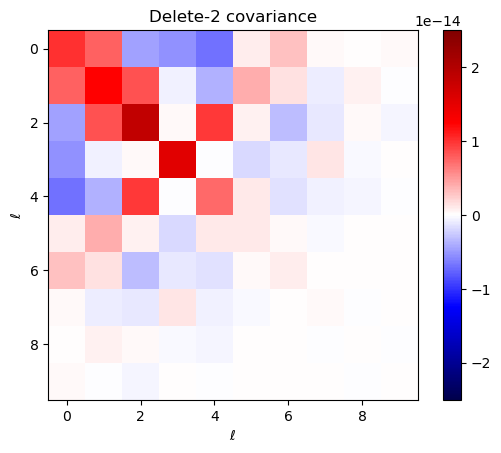

In [20]:
plt.imshow(debiased_cov_jk[("POS", "POS", "POS", "POS", 1, 1, 1, 1)],
           vmin=-2.5*10**-14, vmax=2.5*10**-14, cmap="seismic")
plt.colorbar()
plt.title("Delete-2 covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## DICES Covariance

Finally the DICES covariance is computed as by multiplying the correlation matricies of $\mathbb{C}^{\rm shrunk \, 1}$ and $\mathbb{C}^{\rm debiased}$:
$$
\mathbb{D} = \left(\frac{\mathbb{C}^{\rm shrunk \, 1}}{\sqrt{\mathbb{C}^{\rm shrunk}_{ii} \mathbb{C}^{\rm shrunk}_{ii} }}\right) \left(\frac{\mathbb{C}^{\rm debiased}}{\sqrt{\mathbb{C}^{\rm debiased}_{ii} \mathbb{C}^{\rm debiased}_{ii}}} \right)\, .
$$

In [21]:
dices_cov = dices.dices_covariance(cqs0, shrunk_cov_jk, debiased_cov_jk)

In [22]:
_delete1_cov = dices.Components2Fields(cqs0, cov_jk)
_dices_cov = dices.Components2Fields(cqs0, dices_cov)

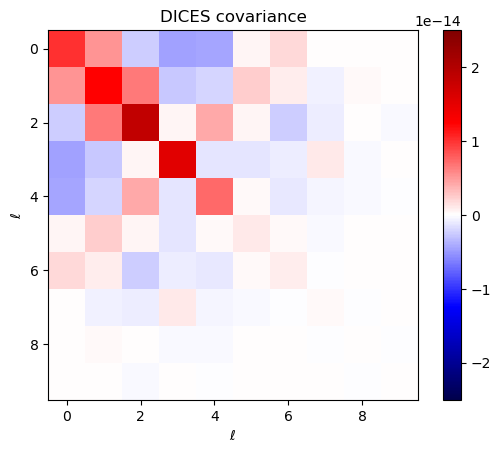

In [23]:
plt.imshow(dices_cov[("POS", "POS", "POS", "POS", 1, 1, 1, 1)],
           vmin=-2.5*10**-14, vmax=2.5*10**-14, cmap="seismic")
plt.colorbar()
plt.title("DICES covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## Results

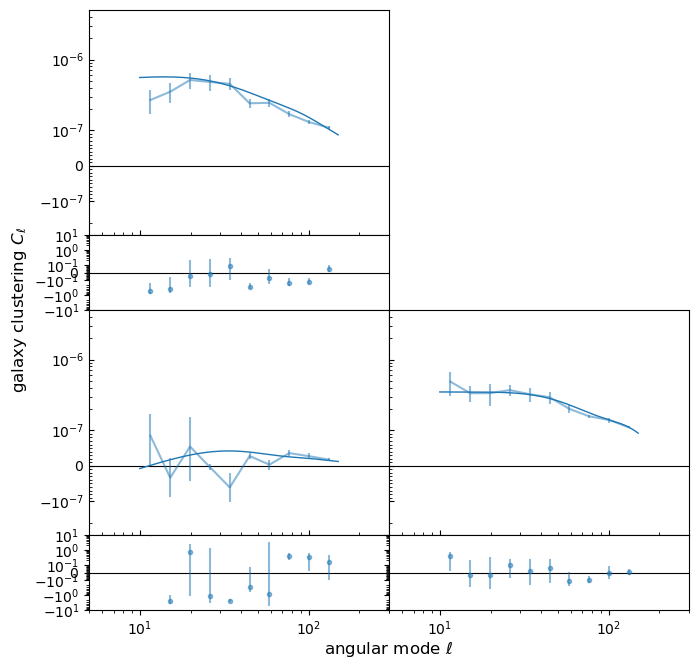

In [24]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)


for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        cov_key = ("POS", "POS", "POS", "POS", i, j, i, j)
        c = _dices_cov[cov_key][0, 0, :, :]
        err = np.sqrt(np.diag(c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, cqs0[key], yerr=err, c="C0", lw=1.5, zorder=3.0, alpha=0.5
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory_cls[key][10:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][:] - heracles.binned(theory_cls[key][1:], ledges))
            / heracles.binned(theory_cls[key][1:], ledges),
            yerr=np.abs(err / cqs0[key][:]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)

        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-7, 5e-6)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])


fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

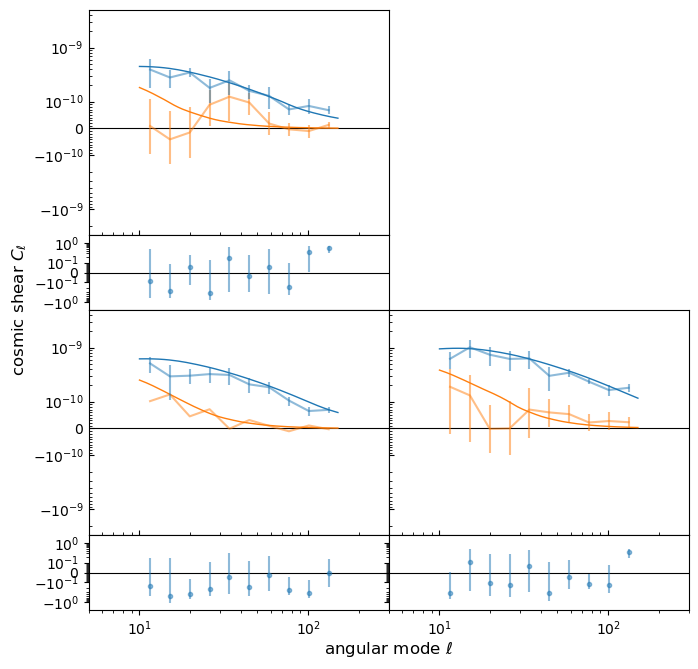

In [25]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        cov_key = ("SHE", "SHE", "SHE", "SHE", i, j, i, j)
        e_c = _delete1_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _delete1_cov[cov_key][1, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory_cls[key][0, 10:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][0, :] - heracles.binned(theory_cls[key][0, 2:], ledges))
            / heracles.binned(theory_cls[key][0, 2:], ledges),
            yerr=np.abs(e_err / cqs0[key][0, :]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:],
            theory_cls[key][1, 10:],
            c="C1",
            lw=1.0,
            zorder=2.0,
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-9, 5e-9)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-2.5, 2.5)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
# ax[0, 0].set_yscale(
#    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
# )
# ax[0, 0].set_ylim(-3e-7, 5e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_42417/3816991813.py:15: RuntimeWarning: invalid value encountered in sqrt
  b_err = np.sqrt(np.diag(b_c))
/tmp/ipykernel_42417/3816991813.py:15: RuntimeWarning: invalid value encountered in sqrt
  b_err = np.sqrt(np.diag(b_c))


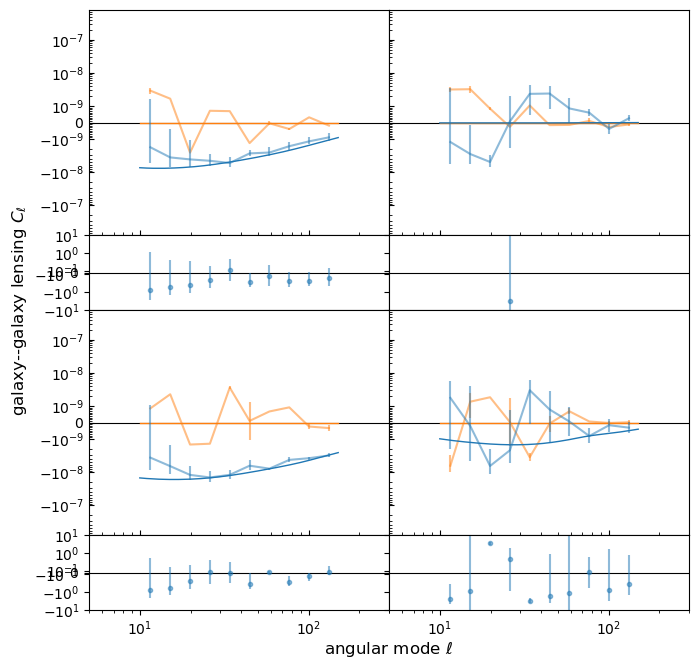

In [26]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    (nbins - 1),
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "SHE", i, j)
        cov_key = ("POS", "SHE", "POS", "SHE", i, j, i, j)
        e_c = _dices_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _dices_cov[cov_key][0, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory_cls[key][0, 10:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][0, :] - heracles.binned(theory_cls[key][0, 2:], ledges))
            / heracles.binned(theory_cls[key][0, 2:], ledges),
            yerr=np.abs(e_err / cqs0[key][0, :]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory_cls[key][1, 10:], c="C1", lw=1.0, zorder=2.0
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")

        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-8e-7, 8e-7)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog",
            linthresh=0.1,
            linscale=0.1,
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])

# ax[0, 0].set_xscale("log")
# ax[0, 0].set_xlim(1 / 2, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
# ax[0, 0].set_yscale(
#    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
# )
# ax[0, 0].set_ylim(-8e-7, 4e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()